## Import necessary libraries

In [1]:
from math import sqrt
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy.stats as stats

## Read the dataset

In [2]:
df = pd.read_csv('HASU Historical Data(2).csv')

## Extarct only the relavant data

In [3]:
data = pd.DataFrame(df[['Date', 'Price']])

## Create time index

In [4]:
# create time indexes
data['time_index'] = list(range(0,df.shape[0]))

## Take the log return values

In [5]:
logreturn = np.zeros(df.shape[0])
logreturn[0] = 0
x = data['Price']
for i in range(1,df.shape[0]-1):
    logreturn[i+1] = math.log(x[i]) - math.log(x[i-1])

data['log_return'] = logreturn

In [6]:
# calculating mean and variance of log_return
mean = np.mean(data['log_return'])
variance = np.var(data['log_return'])

print('Mean of log returns:',mean)
print('Variance of log returns:',variance)

Mean of log returns: 0.0011851389785291228
Variance of log returns: 0.0005445283816906561


In [7]:
# calculating drift parameter and scale parameter
scale_parameter = sqrt(variance)
drift_parameter = mean + (variance/2)

print('Estimated drift parameter µGB: ',drift_parameter)
print('Estimated scale parameter σ: ',scale_parameter)

Estimated drift parameter µGB:  0.001457403169374451
Estimated scale parameter σ:  0.023335131919289768


## Checking the normality of lod returns

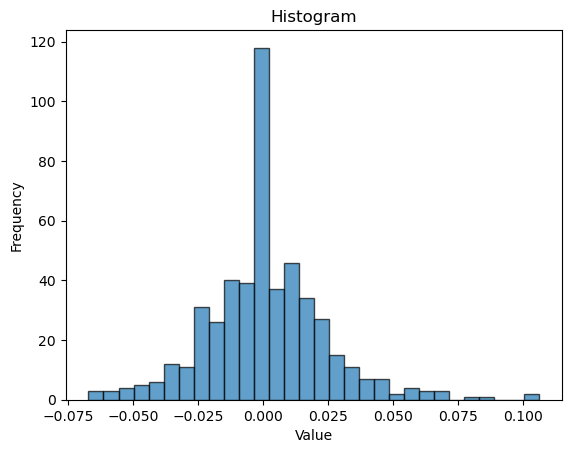

In [8]:
# Plot the histrogram
plt.hist(data['log_return'], bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

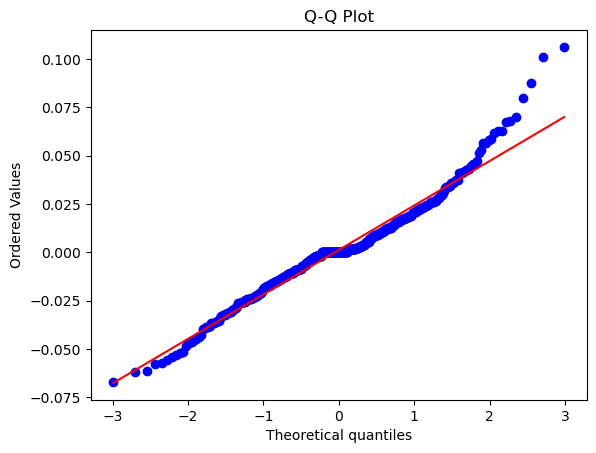

In [9]:
# Plot the Q-Q plot
stats.probplot(data['log_return'], dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

In [10]:
# Perform the Shapiro-Wilk test
stat, p_value = stats.shapiro(data['log_return'])

print('The Shapiro-Wilk test p-value: ',p_value)
print('The Shapiro-Wilk test statistic: ',stat)

# Interpret the results
alpha = 0.05
if p_value > alpha:
    print('Sample looks normally distrubute.')
else:
    print('Sample does not look normally distrubute.')

The Shapiro-Wilk test p-value:  8.210318536150396e-10
The Shapiro-Wilk test statistic:  0.9633312821388245
Sample does not look normally distrubute.


## Function to simulate Geometric Brownian motion

In [11]:
def BrownianG (m,T,N,sigma,mu,w0,GB=False):
    """
    m - number of sample paths
    T - total time
    sigma - scale parameter
    N - number of steps
    mu - drift parameter
    w0 - starting value

    function returns numpy array with shape (m, N+1), 
    first column gives the initial values for each path.
    """
    # time step
    dt = T/N
    # creating a array to store simulated vlues
    x = np.zeros((m, N+1))
    # initial values of x
    x[:,0] = w0
    x0 = x[:,0]

    if not GB:
        # for each element of x0, generate a sample of n numbers from normal distribution
        r = norm.rvs(size = x0.shape + (N,), loc = mu*dt, scale = sigma*sqrt(dt))
        # this computes Broenian motion by taking cumulative som of random samples
        np.cumsum(r, axis = -1, out = x[:,1:])
        # adding initial value
        x[:,1:] += w0

    else:
        r = norm.rvs(size = x0.shape + (N,), loc = mu*dt, scale = sigma*sqrt(dt))
        # this computes Brownian motion by taking cumulative sum of random samples
        np.cumsum(r, axis = -1, out = x[:,1:])
        if w0 != 0:
            x[:,1:] = w0*np.exp(x[:,1:])
        else:
            x[:,1:] = np.exp(x[:,1:])

    return x

In [22]:
# Simulate 5000 possible sample paths for the closing price of HASU relevant to the next 20 days using Geometric Brownian motion
y = BrownianG(5000,20,500,scale_parameter,drift_parameter,x[df.shape[0]-1],GB=True)

## Function to plot sample paths

In [23]:
def BrownianPlot (y,T):
    """
    y - Array with shape (m, N+1). Each row gives discritized verson of a sample path. There are m sample paths.
    T - Total time.

    Returns a graph of all sample paths.
    """

    # Number of steps
    N = y.shape[1]
    # Length of time step
    dt = T/(N-1)

    t = np.linspace(0.0, N*dt, N)
    for k in range(y.shape[1]):
        plt.plot(t, y[k])
    plt.title('5000 sample paths', fontsize = 20)
    plt.xlabel('time', fontsize = 15)
    plt.ylabel('W_t', fontsize = 15)

    # Show the grid line as dark grey line
    plt.grid(True)
    plt.show()

## Function to plot Histrogram of end values

In [14]:
def BrownianEnd (y, T, loc):
    """
    y - Array with shape (m, N+1). Each row gives discritized verson of a sample path. There are m sample paths.
    T - Total time.
    loc - location to graph

    Returns a histrogram of values which are obtained by discritising the sample paths at the given location.
    """

    # Number of steps
    N = y.shape[1]
    # Length of a step
    dt = T/(N-1)
    # The possision of the array corresponding to the given location
    pos = int(loc/dt)

    # Histrgram
    plt.hist(y[:,pos], bins=25, density=True)
    plt.show()

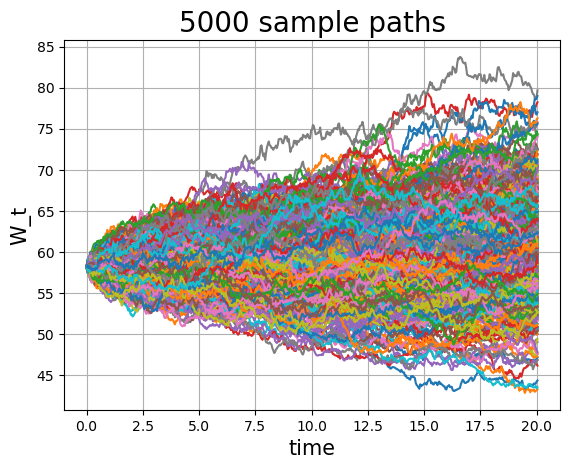

In [24]:
 BrownianPlot (y,20)

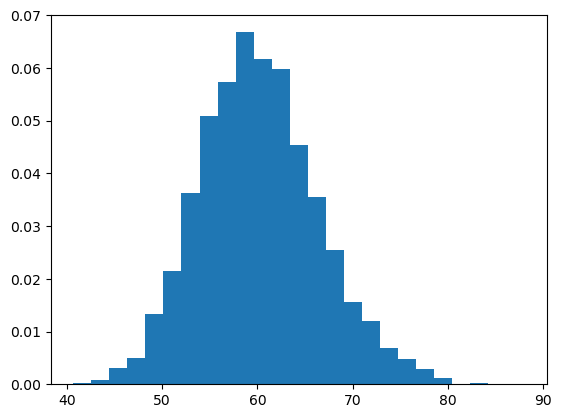

In [16]:
BrownianEnd (y, 20, 20)

In [17]:
# Make a Data Frame using simulated values
dfBM = pd.DataFrame(y.T)

# Get discriptive statistics of predicted values corresponding to the last day of the next 20-day period
endvalues = dfBM.loc[500]
endvalues.describe()

count    5000.000000
mean       60.211711
std         6.243429
min        40.640882
25%        55.817463
50%        59.857259
75%        64.125483
max        88.039647
Name: 500, dtype: float64

Text(0.5, 0, 'last day of the next 20-day period')

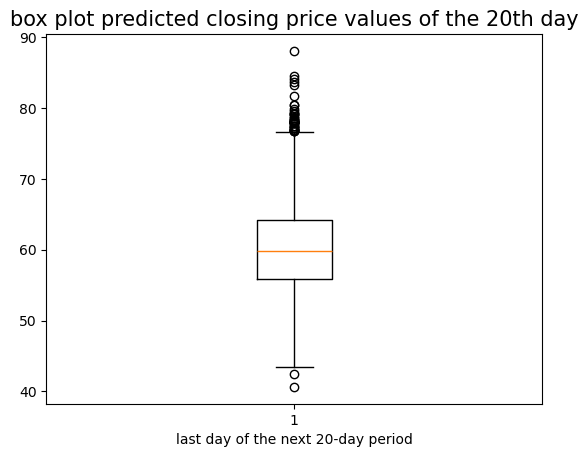

In [18]:
# Create a box plot for the possible closing price values of HASU corresponding to the last day of the next 20-day period
plt.boxplot(endvalues)
plt.title('box plot predicted closing price values of the 20th day', fontsize = 15)
plt.xlabel('last day of the next 20-day period', fontsize = 10)


In [19]:
# Calculating the probability that the closing price corresponding to the last day of 20th day is between 55 and 60
a = len(endvalues[(endvalues<60) & (endvalues>55)])/len(endvalues)
print('probability that the closing price corresponding to the last day of the 20th day is between 55 and 60: ',a)

probability that the closing price corresponding to the last day of the 20th day is between 55 and 60:  0.3044


In [20]:
# The 95% prediction interval for the closing price value corresponding to the last day of the next 20-day period
b = np.percentile(endvalues,[2.5,97.5])
print('The 95% prediction interval for the closing price value of 20th day: ',b)

The 95% prediction interval for the closing price value of 20th day:  [48.78724187 73.49927723]
